In [17]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
pbp = nfl.import_pbp_data([2025])
sched = nfl.import_schedules([2025])

2025 done.
Downcasting floats.


Logos

In [ ]:
TEAM_LOGOS = {
    "ARI": "https://upload.wikimedia.org/wikipedia/en/thumb/7/72/Arizona_Cardinals_logo.svg/512px-Arizona_Cardinals_logo.svg.png",
    "ATL": "https://upload.wikimedia.org/wikipedia/en/thumb/c/c5/Atlanta_Falcons_logo.svg/120px-Atlanta_Falcons_logo.svg.png",
    "BAL": "https://upload.wikimedia.org/wikipedia/en/thumb/1/16/Baltimore_Ravens_logo.svg/120px-Baltimore_Ravens_logo.svg.png",
    "BUF": "https://a.espncdn.com/i/teamlogos/nfl/500/buf.png",
    # ...
}

## 1. Turnover Margin vs. Wins

In [19]:
turnovers = pbp[
    (pbp["season_type"] == "REG") &
    ((pbp["interception"] == 1) | (pbp["fumble_lost"] == 1))
]

# Offense commits turnover
off_tos = turnovers.groupby("posteam").size()

# Defense forces turnover
def_tos = turnovers.groupby("defteam").size()

to_df = (
    pd.DataFrame({
        "offensive_turnovers": off_tos,
        "defensive_takeaways": def_tos
    })
    .fillna(0)
)

to_df["turnover_margin"] = (
    to_df["defensive_takeaways"] - to_df["offensive_turnovers"]
)


Wins per team

In [20]:
sched["home_win"] = sched["home_score"] > sched["away_score"]
sched["away_win"] = sched["away_score"] > sched["home_score"]

home_wins = sched.groupby("home_team")["home_win"].sum()
away_wins = sched.groupby("away_team")["away_win"].sum()

wins = home_wins.add(away_wins, fill_value=0).rename("wins")


<Axes: title={'center': 'Turnover Margin vs Wins (2025)'}, xlabel='turnover_margin', ylabel='wins'>

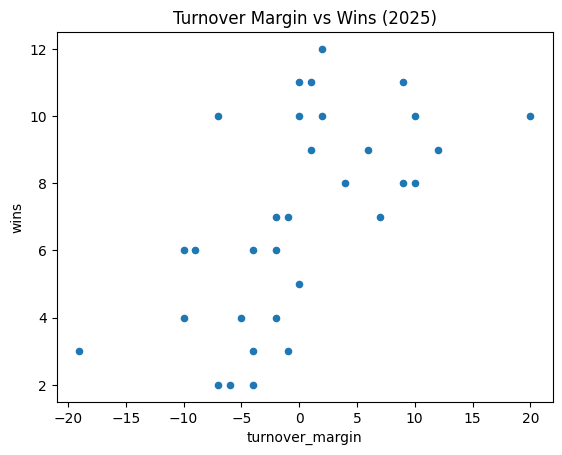

In [21]:
df = to_df.join(wins)

df.plot(
    kind="scatter",
    x="turnover_margin",
    y="wins",
    title="Turnover Margin vs Wins (2025)",
)


## 2. Red zone efficiency ranking

In [22]:
rz = pbp[
    (pbp["season_type"] == "REG") &
    (pbp["yardline_100"] <= 20) &
    ((pbp["pass"] == 1) | (pbp["rush"] == 1))
]

In [23]:
rz_summary = (
    rz.groupby("posteam")
    .agg(
        rz_plays=("play_id", "count"),
        rz_tds=("touchdown", "sum")
    )
)

rz_summary["td_rate"] = rz_summary["rz_tds"] / rz_summary["rz_plays"]
rz_summary = rz_summary.sort_values("td_rate", ascending=False)


<Axes: title={'center': 'Top 15 Red Zone Touchdown Rates (2025)'}, xlabel='Touchdown Rate', ylabel='Team'>

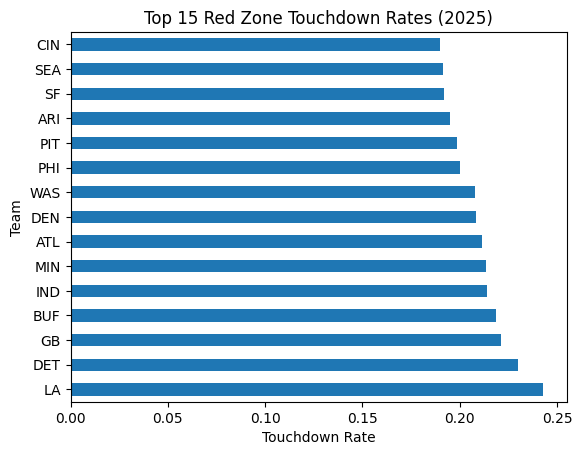

In [24]:
rz_summary["td_rate"].head(15).plot(
    kind="barh",
    title="Top 15 Red Zone Touchdown Rates (2025)",
    xlabel="Touchdown Rate",
    ylabel="Team"
)


## 3. Fourth down agression

In [25]:
fourth = pbp[
    (pbp["season_type"] == "REG") &
    (pbp["down"] == 4) &
    (pbp["yardline_100"].between(20, 80))
]


In [26]:
fourth["go_for_it"] = ~fourth["play_type"].isin(["punt", "field_goal"])

/var/folders/mk/354ykzvd4xb9dv44bwrmk9w80000gn/T/ipykernel_77208/3921050256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth["go_for_it"] = ~fourth["play_type"].isin(["punt", "field_goal"])


In [27]:
fourth["ydstogo_bin"] = pd.cut(
    fourth["ydstogo"],
    bins=[0, 2, 5, 10, 100]
)

heatmap_data = (
    fourth
    .groupby(["ydstogo_bin", "yardline_100"])["go_for_it"]
    .mean()
    .unstack()
)

/var/folders/mk/354ykzvd4xb9dv44bwrmk9w80000gn/T/ipykernel_77208/3242503893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth["ydstogo_bin"] = pd.cut(


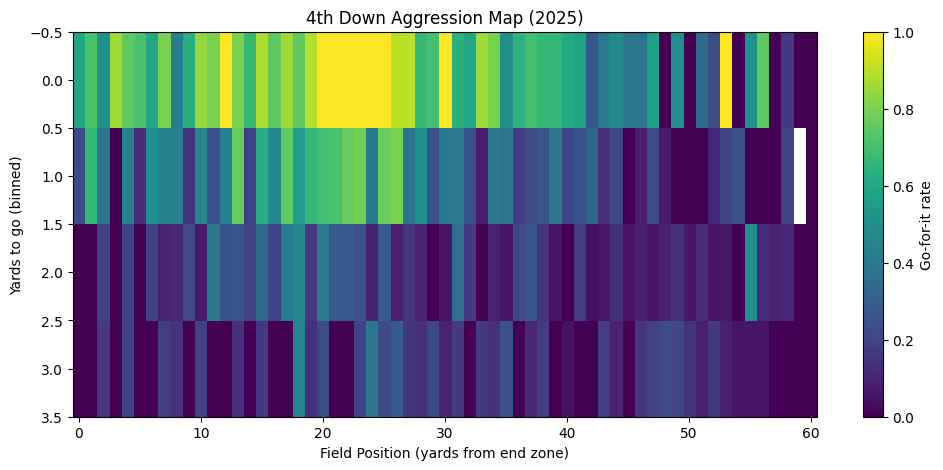

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.imshow(heatmap_data, aspect="auto")
plt.colorbar(label="Go-for-it rate")
plt.title("4th Down Aggression Map (2025)")
plt.xlabel("Field Position (yards from end zone)")
plt.ylabel("Yards to go (binned)")
plt.show()
